In [1]:
# Imports 

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
# Paths 

DATA_DIR_PATH = 'data'

In [3]:
# Import DVF data (https://app.dvf.etalab.gouv.fr/) 

csv_file_list = [file.name for file in os.scandir(DATA_DIR_PATH) if file.name.endswith('.csv')]

df = pd.DataFrame()

transac_count = 0

for file in csv_file_list:
    new_file = pd.read_csv(os.path.join(DATA_DIR_PATH, file), sep=';')
    new_file['section']=file[9:11]
    transac_count += len(new_file)
    df = pd.concat([df,new_file], ignore_index=True)

#transac_count == len(df)

In [4]:
df.set_index('id_mutation', inplace=True)

In [5]:
df.date_mutation = pd.to_datetime(df.date_mutation)

In [6]:
df.surface_terrain = df.surface_terrain.fillna(0)
df.nombre_pieces_principales = df.nombre_pieces_principales.fillna(0)

In [7]:
#df['nombre_lots'].isna().sum()
#df['type_local'].isna().sum()
#df['surface_reelle_bati'].isna().sum()
#df['nombre_pieces_principales'].isna().sum()

In [8]:
df.section_prefixe = df.section_prefixe.apply(lambda x: x.replace('0', ''))

In [9]:
# drop unnecessary data

df.drop(columns=['numero_disposition', 'code_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 
                 'ancien_id_parcelle', 'adresse_suffixe','adresse_code_voie', 'lot1_numero', 'lot2_numero', 'lot3_numero', 
                 'lot4_numero', 'lot5_numero', 'lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez', 'section_prefixe',
                 'lot4_surface_carrez', 'lot5_surface_carrez', 'nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 
                 'code_type_local', 'nature_culture', 'code_nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale']
        , inplace=True)

In [10]:
# Add inondation risk information (info from https://georisques.gouv.fr/)

quartier_risque_df = pd.read_csv('section-inondable.csv', sep=';')
df = pd.merge(df, quartier_risque_df, how='left', left_on='section',right_on='section_prefixe')

In [11]:
# Filter according to transaction type, date, and reshuffle

df_filtered = df[(df.nature_mutation.isin(['Vente', "Vente en l'état futur d'achèvement"])) &
         (df.type_local.isin(['Appartement', 'Maison'])) &
         (df.date_mutation > '2022-01-01')] # price/m2 roughly stable in St Malo since 2022

df_filtered = df_filtered.sample(frac=1, random_state=42).reset_index(False)

In [12]:
# Encode "maison ou appartement"

df_filtered['maison'] = (df_filtered['type_local'] == "Maison").astype(int)
df.drop(columns=['type_local'], inplace=True)

In [13]:
# Drop outliers

df_filtered = df_filtered[df_filtered['surface_terrain'] < 300]
df_filtered = df_filtered[df_filtered['surface_reelle_bati'] < 500]

In [14]:
# Create X and y

X = df_filtered[[ 'maison', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'risque']]
y = df_filtered['valeur_fonciere']/1000

In [15]:
# Create train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<u>1. Baseline model</u>

In [16]:
mean_price_sqm = y_train.sum()/X_train.surface_reelle_bati.sum()

In [17]:
y_pred = X_test['surface_reelle_bati']*mean_price_sqm

In [18]:
r2_score(y_pred, y_test)

0.5602637188284466

<u>2. Linear regression</u>

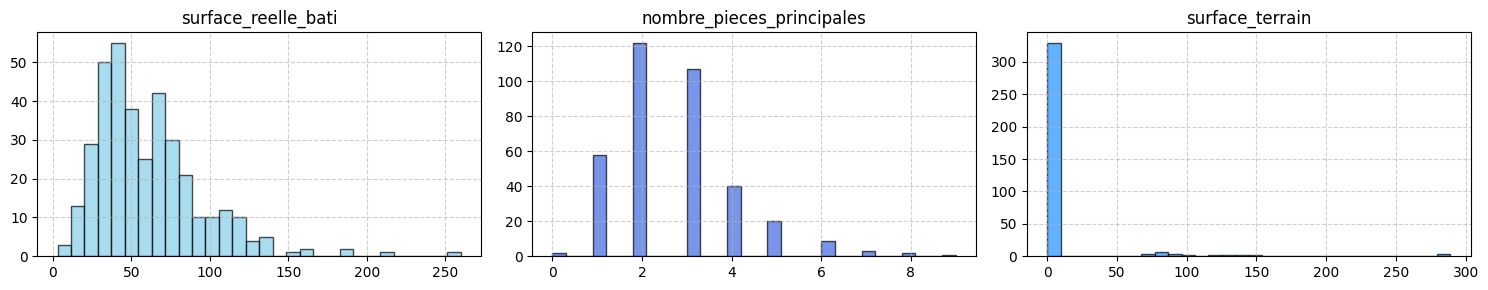

In [19]:
# Plot distribution

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
columns = ['surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain']
colors = ['skyblue', 'royalblue', 'dodgerblue']

for ax, col, color in zip(axes.flatten(), columns, colors):
    ax.hist(df_filtered[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [20]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [21]:
standard_scaler = StandardScaler()

In [22]:
X_train_scaled[['surface_reelle_bati']] = standard_scaler.fit_transform(X_train_scaled[['surface_reelle_bati']])
X_test_scaled[['surface_reelle_bati']] = standard_scaler.transform(X_test_scaled[['surface_reelle_bati']])

In [23]:
X_train_scaled[['nombre_pieces_principales']] = standard_scaler.fit_transform(X_train_scaled[['nombre_pieces_principales']])
X_test_scaled[['nombre_pieces_principales']] = standard_scaler.transform(X_test_scaled[['nombre_pieces_principales']])

In [24]:
minmax_scaler = MinMaxScaler()

In [25]:
X_train_scaled[['surface_terrain']] = minmax_scaler.fit_transform(X_train_scaled[['surface_terrain']])
X_test_scaled[['surface_terrain']] = minmax_scaler.transform(X_test_scaled[['surface_terrain']])

In [26]:
linear_model = LinearRegression()

In [27]:
cv_scores_linear_baseline = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='r2')

In [28]:
cv_scores_linear_baseline.mean()

0.5969791062165039

In [29]:
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [30]:
linear_model.score(X_test_scaled, y_test)

0.71846073352148

<u>3. XGBoostRegressor</u>

In [31]:
xgb_regressor_baseline = XGBRegressor()

In [32]:
cv_score_xgb_baseline = cross_val_score(xgb_regressor_baseline, X_train, y_train, cv=5, scoring='r2')

In [33]:
cv_score_xgb_baseline.mean()

0.5419937526222939

In [34]:
xgb_params = {
            'n_estimators': [int(x) for x in np.linspace(start = 70, stop = 90, num = 10)],
            'max_depth' : [None, 1, 2, 4],
            'min_child_weight': [None, 1, 5],
            'gamma': [0.5, 1, 1.5, 2, 5],
        }

xgb_search = GridSearchCV(estimator = xgb_regressor_baseline,
                                   param_grid = xgb_params,
                                   scoring='neg_mean_absolute_error',
                                   cv = 5,
                                   verbose=1,
                                   n_jobs = -1)

xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.5, 1, 1.5, 2, 5],
                         'max_depth': [None, 1, 2, 4],
                         'min_child_weight': [None, 1, 5],
                         'n_estimators': [70, 72, 74, 76, 78, 81, 83, 85, 87,
                                          90]},
             scoring='neg_mean_absolute_error', verbose=1)

In [35]:
xgb_best = xgb_search.best_estimator_

In [36]:
cv_scores_best_xgb = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='r2')

In [37]:
cv_scores_best_xgb.mean()

0.64135462189927

In [38]:
# score OK given the scarcity of transaction data

In [39]:
xgb_best.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=87, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
xgb_best.score(X_test,y_test)

0.6962854643931469

In [41]:
new_value = {'maison':0,'surface_reelle_bati':66,'nombre_pieces_principales':1,'surface_terrain':5,'risque':0}

In [42]:
new_value = pd.DataFrame([new_value])

In [43]:
new_value

,maison,surface_reelle_bati,nombre_pieces_principales,surface_terrain,risque
0,0,66,1,5,0


In [44]:
xgb_best.predict(new_value)

array([290.79422], dtype=float32)